## Entrenamiento de modelos.

### Vamos a entrenar modelos para predecir si tendremos problemas con un cliente o no.

Las columnas de Product, Sub_product, Issue, Sub-issue nos describien el problema.<br>
Las columnas: State, Zip code la ubicación geográfica.<br>
Las columnas: Company response, Timely response?, Consumer disputed? pueden ser
variables objetivo o para análisis de calidad.

Se han utilizado las métricas de clasificación para la evaluación de modelos, ya que el orbjetivo es predecir categorías, en nuestro proyecto si el cliente va a disputará una queja: Sí o No.

In [173]:
# Importación
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



### Limpieza inicial de datos.

In [174]:
df= pd.read_csv('../data/datos_procesados.csv')


In [175]:
df.drop(columns=['Complaint ID', 'Date received', 'Date sent to company'], inplace=True)

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6006 entries, 0 to 6005
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Product             6006 non-null   object
 1   Sub-product         6006 non-null   object
 2   Issue               6006 non-null   object
 3   Sub-issue           6006 non-null   object
 4   State               6006 non-null   object
 5   ZIP code            6006 non-null   object
 6   Company             6006 non-null   object
 7   Company response    6006 non-null   object
 8   Timely response?    6006 non-null   object
 9   Consumer disputed?  6006 non-null   object
dtypes: object(10)
memory usage: 469.3+ KB


In [177]:
df.isnull().sum()

Product               0
Sub-product           0
Issue                 0
Sub-issue             0
State                 0
ZIP code              0
Company               0
Company response      0
Timely response?      0
Consumer disputed?    0
dtype: int64

## Preprocesado de datos.

Ya que se dispone de datos nulos (en el análisis EDA se indica 'Unknown' para rellenar nulos) el preprocesado ayuda a ajustar el peso de la variables. 

Los modelos matemáticos necesitan números para operar pero los campos escogidos no tienen un orden numérico natural.
Los algoritnos de Machine Learning no entienden texto, así que necesitamos que cada categoría se convierta en una representación numérica.

In [178]:
# Crear variable objetivo
df['Disputa'] = df['Consumer disputed?'].map({"Yes": 1, "No": 0})

# Rellenar nulos en columnas categóricas antes de codificar
categoricas = ["Product", "Sub-product", "Issue", "Sub-issue", "State", "Company", "Company response","ZIP code", "Timely response?"]
for col in categoricas:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown").astype(str).str.strip().str.lower()

# Codificación one-hot
df_modelo = pd.get_dummies(df, columns=categoricas, drop_first=True)

# Selección de variables
X = df_modelo.drop(columns=['Consumer disputed?', 'Disputa'])
print(X.select_dtypes(include='object').columns)

y = df_modelo['Disputa']


Index([], dtype='object')


In [179]:
print(X.dtypes)


Product_consumer loan       bool
Product_credit card         bool
Product_credit reporting    bool
Product_debt collection     bool
Product_money transfers     bool
                            ... 
ZIP code_99516              bool
ZIP code_99686              bool
ZIP code_99712              bool
ZIP code_unknown            bool
Timely response?_yes        bool
Length: 4836, dtype: object


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [181]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### **Modelos Supervisados**
### 1. Regresión Logística

In [182]:
modelo_lr=LogisticRegression(max_iter=1000, class_weight='balanced')
modelo_lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### 2. Árbol de decisión

In [183]:
modelo_dt = DecisionTreeClassifier()
modelo_dt.fit(X_train, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### 3. Random Forest

In [184]:
modelo_rf = RandomForestClassifier()
modelo_rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [185]:
y_proba = modelo_rf.predict_proba(X_test)[:, 1]
umbrales = np.arange(0.3, 0.8, 0.05)
for u in umbrales:
    y_pred = (y_proba >= u).astype(int)
    precision = precision_score(y_test, y_pred)
    print(f"Umbral: {u:.2f} → Precisión: {precision:.3f}")
umbral = 0.6  # o el valor que prefieras
y_pred_ajustado = (y_proba >= umbral).astype(int)


Umbral: 0.30 → Precisión: 0.784
Umbral: 0.35 → Precisión: 0.786
Umbral: 0.40 → Precisión: 0.791
Umbral: 0.45 → Precisión: 0.793
Umbral: 0.50 → Precisión: 0.798
Umbral: 0.55 → Precisión: 0.801
Umbral: 0.60 → Precisión: 0.810
Umbral: 0.65 → Precisión: 0.817
Umbral: 0.70 → Precisión: 0.821
Umbral: 0.75 → Precisión: 0.829


Matriz de confusión con umbral ajustado:
[[ 51 211]
 [ 43 897]]
Reporte de clasificación:
              precision    recall  f1-score   support

  No Disputa       0.54      0.19      0.29       262
     Disputa       0.81      0.95      0.88       940

    accuracy                           0.79      1202
   macro avg       0.68      0.57      0.58      1202
weighted avg       0.75      0.79      0.75      1202



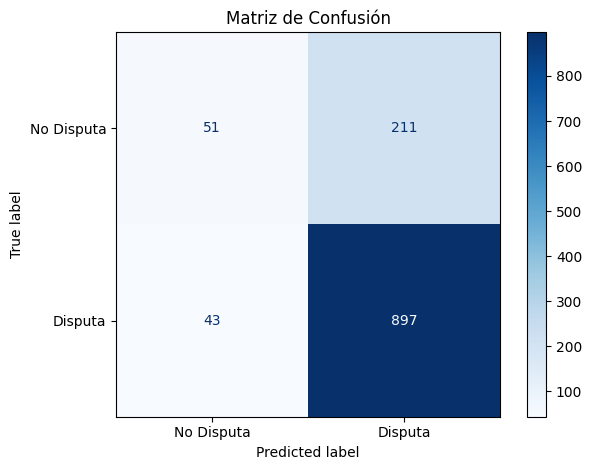

In [186]:
from sklearn.metrics import confusion_matrix, classification_report

matriz = confusion_matrix(y_test, y_pred_ajustado)
print("Matriz de confusión con umbral ajustado:")
print(matriz)

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_ajustado, target_names=["No Disputa", "Disputa"]))

disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=["No Disputa", "Disputa"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()


### 4. K-Nearest Neighbors

In [187]:
modelo_knn = KNeighborsClassifier()
modelo_knn.fit(X_train, y_train)


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


### 5. Support Vector Machine

In [188]:
modelo_svm = SVC()
modelo_svm.fit(X_train, y_train)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


### EVALUACIÓN DE MODELOS

In [189]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluar_modelo(modelo, nombre):
    y_pred = modelo.predict(X_test)
    print(f"Evaluación de {nombre}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("-" * 40)

# Evaluar todos
evaluar_modelo(modelo_lr, "Regresión Logística")
evaluar_modelo(modelo_dt, "Árbol de Decisión")
evaluar_modelo(modelo_rf, "Random Forest")
evaluar_modelo(modelo_knn, "KNN")
evaluar_modelo(modelo_svm, "SVM")


Evaluación de Regresión Logística
Accuracy: 0.697171381031614
Precision: 0.8110151187904968
Recall: 0.798936170212766
F1 Score: 0.804930332261522
----------------------------------------
Evaluación de Árbol de Decisión
Accuracy: 0.7529118136439268
Precision: 0.804739336492891
Recall: 0.9031914893617021
F1 Score: 0.8511278195488722
----------------------------------------
Evaluación de Random Forest
Accuracy: 0.7920133111480865
Precision: 0.7984429065743944
Recall: 0.9819148936170212
F1 Score: 0.8807251908396947
----------------------------------------
Evaluación de KNN
Accuracy: 0.7778702163061564
Precision: 0.7873612297181896
Recall: 0.9808510638297873
F1 Score: 0.8735196589294173
----------------------------------------
Evaluación de SVM
Accuracy: 0.7853577371048253
Precision: 0.7860738255033557
Recall: 0.9968085106382979
F1 Score: 0.8789868667917449
----------------------------------------


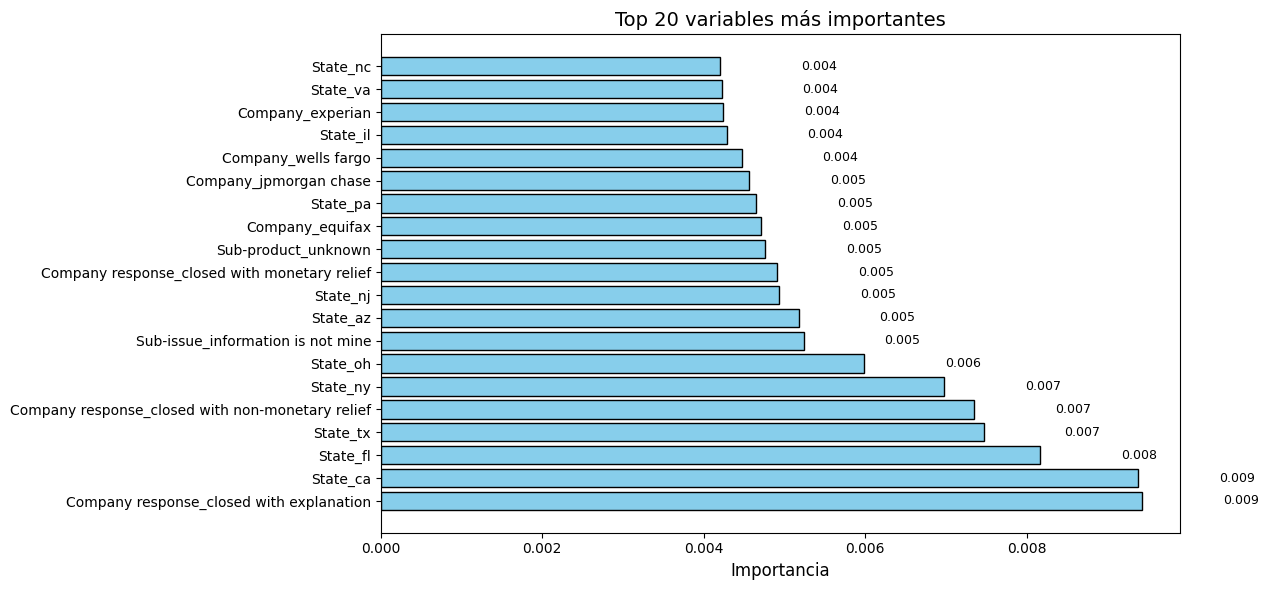

In [190]:
# Interpretación de variables

import matplotlib.pyplot as plt
import numpy as np

importancias = modelo_rf.feature_importances_
nombres = X.columns
indices = np.argsort(importancias)[::-1]

top_n = 20
plt.figure(figsize=(12, 6))
plt.title(f"Top {top_n} variables más importantes", fontsize=14)

plt.barh(
    range(top_n),
    importancias[indices[:top_n]][::-1],
    color='skyblue',
    edgecolor='black'
)
plt.yticks(
    range(top_n),
    nombres[indices[:top_n]][::-1],
    fontsize=10
)
plt.xlabel("Importancia", fontsize=12)
plt.tight_layout()
plt.gca().invert_yaxis()
for i, v in enumerate(importancias[indices[:top_n]][::-1]):
    plt.text(v + 0.001, i, f"{v:.3f}", va='center', fontsize=9)
plt.show()



### 6. Modelo No Supervidado (KMeans)

In [191]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmean=KMeans(n_clusters=4, random_state=42)
clusters = kmean.fit_predict(X_scaled)
df_modelo['cluster'] = clusters


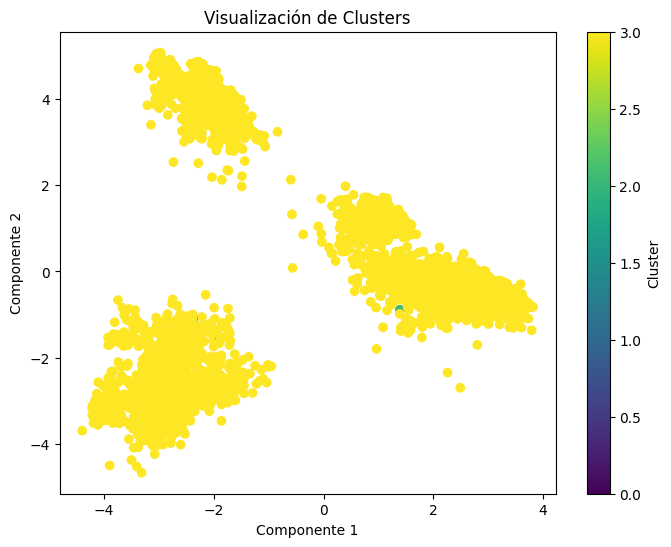

In [192]:
# Visualización de grupos

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="viridis")
plt.title("Visualización de Clusters")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.colorbar(label="Cluster")
plt.show()


In [193]:
import joblib
joblib.dump(modelo_rf, "../models/modelo_random_forest.pkl")


['../models/modelo_random_forest.pkl']